# Installing Transformer and imports

In [101]:
# from google.colab import drive

# drive.mount('/content/gdrive/')

Importing useful libraries

In [71]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
import tensorflow as tf
import seaborn as sns
# import tensorflow_datasets as tfds
from bs4 import BeautifulSoup
from sklearn import metrics as sk_metrics
import nltk
import re
from sklearn.utils import shuffle
import tqdm as notebook_tqdm

# Data read and split...for some accuracy numbers

In [72]:
col_list = ["id", "tweet", "labels"]
our_data = pd.read_csv("/content/symptoms_train.csv",usecols=col_list)
df_test = pd.read_csv("/content/symp_test.csv")
y_map = {
    'non-reporting': 0, 
    'third-party': 1, 
    'primary': 2,
    'secondary':3
}

our_data['Sentiment_Cat'] = our_data['labels'].map(y_map)

## showing train data

In [73]:
our_data

,id,tweet,labels,Sentiment_Cat
0,1322367936405921794,uh oh the coughs have started covid is taking ...,non-reporting,0
1,1262153405553946624,"Loss of smell, confusion, strokes: Does Covid-...",non-reporting,0
2,1324014644931878912,"""AI is being used to distinguish between asymp...",non-reporting,0
3,1313660639097823232,i was v ill for the last couple of days (high ...,non-reporting,0
4,1239223445306695680,Played warzone yesterday with a dude who caugh...,third-party,1
...,...,...,...,...
1569,1247792485239156738,@CCriadoPerez Totally. Murphy’s nose was runni...,third-party,1
1570,1295395700650528775,@kamera26 @Nicholaspkirby I just tested negati...,primary,2
1571,1241381235382984707,Lmao I have a cold or smth And every time I c...,primary,2
1572,1236525788360474629,"fuck the corona virus, all my homies got biebe...",secondary,3


## showing train data

In [74]:
df_test

,id,tweet
0,1242353332817137664t,If you think you have been exposed to COVID-19...
1,1244712715827982339t,"@timbovisser @BBCJohnBeattie Yes, myself, wife..."
2,1314693013810089984t,Lots of people I know having positive covid te...
3,1307860995692527616t,@lizzyp144 @TomAThakkar Okay but doesn’t COVID...
4,1277375421164613632t,We should have people w covid cough on white b...
...,...,...
395,1255420681581404163t,#bbcgms People who don't have COVID-19 cough s...
396,1331420575265394688t,"Fatigue, shortness of breath, muscle aches, he..."
397,1272691373645467653t,I woke up today from my nap and my throat was ...
398,1242065925337018369t,"#coronavirusindia It's just beginning, isolati..."


## Splitting the training dataset into training and validation sets with the help of StratifiedShuffleSplit

In [75]:
from sklearn.model_selection import StratifiedShuffleSplit
df = our_data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_valid_index in split.split(df, df.Sentiment_Cat):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.Sentiment_Cat):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

print(train_set.shape)
print(test_valid_set.shape)
print(test_set.shape)
print(valid_set.shape)

df_train = train_set
df_valid = test_valid_set
# df_test = test_set
# df_valid = valid_set

(1416, 4)
(158, 4)
(79, 4)
(79, 4)


In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1416 entries, 853 to 1310
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1416 non-null   int64 
 1   tweet          1416 non-null   object
 2   labels         1416 non-null   object
 3   Sentiment_Cat  1416 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 55.3+ KB


In [77]:
df_train.Sentiment_Cat.value_counts()

0    732
2    393
1    177
3    114
Name: Sentiment_Cat, dtype: int64

In [106]:
df_valid.Sentiment_Cat.value_counts()

0    82
2    44
1    19
3    13
Name: Sentiment_Cat, dtype: int64

In [79]:
df_train.head()

,id,tweet,labels,Sentiment_Cat
853,1297524815125819392,my grandpa had a couple seizures yesterday and...,secondary,3
1290,1257891188637663232,@MumbaiPolice My family is in Chembur Camp Nea...,secondary,3
40,1249770473447206915,passed jeremy corbyn in the street today. i as...,third-party,1
877,1332394461150765065,@Mythsas I deal with social anxiety amongst ot...,primary,2
1475,1246793961366315009,The W.H.O is advising people to follow five si...,non-reporting,0


## Just showing first tweet in our training set.

In [80]:
df_train['tweet'].iloc[0]

'my grandpa had a couple seizures yesterday and ended up in the hospital. but due to covid, no one could visit. he thankfully got to come home, but knowing that he woke up confused and not knowing what was going on with no one there for him breaks my heart.'

In [81]:
df_test.head()

,id,tweet
0,1242353332817137664t,If you think you have been exposed to COVID-19...
1,1244712715827982339t,"@timbovisser @BBCJohnBeattie Yes, myself, wife..."
2,1314693013810089984t,Lots of people I know having positive covid te...
3,1307860995692527616t,@lizzyp144 @TomAThakkar Okay but doesn’t COVID...
4,1277375421164613632t,We should have people w covid cough on white b...


## Converting "sentiment_cat" column into integer for training purpose.

In [109]:
y_map = {
    'ProVax': 0, 
    'AntiVax': 1, 
    'Neutral': 2
}



df_train['Sentiment_Cat'] = df_train['labels'].map(y_map)
df_valid['Sentiment_Cat'] = df_valid['labels'].map(y_map)  


<ipython-input-109-4494ca8a64af>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Sentiment_Cat'] = df_train['labels'].map(y_map)
<ipython-input-109-4494ca8a64af>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Sentiment_Cat'] = df_valid['labels'].map(y_map)


# Pre-processing

In [83]:
import sys
import re
!pip install emoji --quiet
import emoji
!pip install contractions --quiet
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import unicodedata

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Given below is the function for Stemmizing and cleaning the tweets from training Dataset.

In [110]:
def cleaning(text):
  text= text.lower()
  text= emoji.demojize(text)
  text=contractions.fix(text)
  text=text.strip()
  text=text.replace('[^\w\s]','')
  text=re.sub(r'http\S+', '', text)
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
  text = REPLACE_BY_SPACE_RE.sub(' ' , text)
  text = BAD_SYMBOLS_RE.sub(' ',text)
  
  return text




<ipython-input-110-91db9100634e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet_cleaned'] = df_train['tweet'].apply(cleaning)
<ipython-input-110-91db9100634e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['tweet_cleaned'] = df_valid['tweet'].apply(cleaning)


'my grandpa had a couple seizures yesterday and ended up in the hospital  but due to covid  no one could visit  he thankfully got to come home  but knowing that he woke up confused and not knowing what was going on with no one there for him breaks my heart '

## Cleaning the tweets of Training Data and Cleaning the tweets of Validation Data

In [ ]:
df_train['tweet_cleaned'] = df_train['tweet'].apply(cleaning)
df_test['tweet_cleaned'] = df_test['tweet'].apply(cleaning)
df_valid['tweet_cleaned'] = df_valid['tweet'].apply(cleaning)
df_train['tweet_cleaned'].iloc[0]

## Model Training Starts

In [111]:
x_train, y_train = df_train['tweet_cleaned'].values, np.array(df_train['Sentiment_Cat'], dtype=np.int64)
# x_test, y_test = df_test['tweet_cleaned'].values, np.array(df_test['Sentiment_Cat'], dtype=np.int64)
x_valid, y_valid = df_valid['tweet_cleaned'].values, np.array(df_valid['Sentiment_Cat'], dtype=np.int64)


x_test = df_test['tweet_cleaned'].values

# Data Exploration

In [86]:
data = df_train
non_reporting_data = data[data['Sentiment_Cat'] == 0]
third_party_data = data[data['Sentiment_Cat'] == 1]
primary_data = data[data['Sentiment_Cat'] == 2]
secondary_data = data[data['Sentiment_Cat'] == 3]

#     'non-reporting': 0, 
#     'third-party': 1, 
#     'primary': 2,
#     'secondary':3

## How much Antivax_data ?

In [87]:
# df = Antivax_data
a=[]
for i in range(len(non_reporting_data)):
  a.append(len(non_reporting_data['tweet_cleaned'].iloc[i].split()))
print(max(a))
# df = Provax_data
b=[]
for i in range(len(third_party_data)):
  b.append(len(third_party_data['tweet_cleaned'].iloc[i].split()))
print(max(b))
# df = Neutral_data



95
61
69
76
732 177 393 114


## How much Provax data ?

In [ ]:
c=[]
for i in range(len(primary_data)):
  c.append(len(primary_data['tweet_cleaned'].iloc[i].split()))
print(max(c))

##How much Neutral data ?**

In [ ]:
d=[]
for i in range(len(secondary_data)):
  d.append(len(secondary_data['tweet_cleaned'].iloc[i].split()))
print(max(d))
print(len(non_reporting_data), len(third_party_data), len(primary_data), len(secondary_data))

## Representing Frequency of words in each tweet corresponding to Antivax, Provax and neutral Data

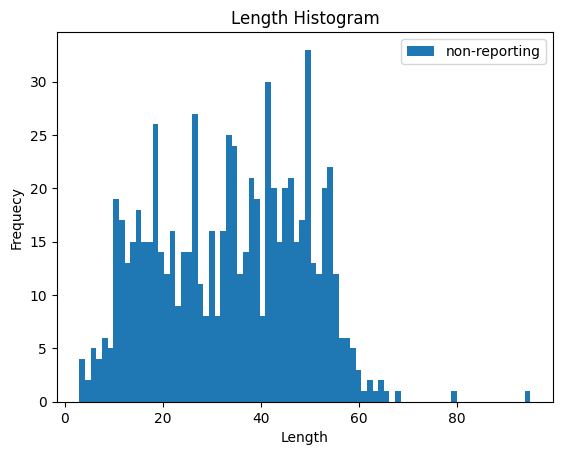

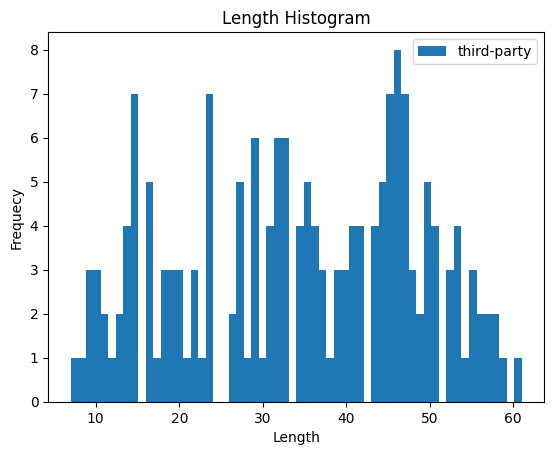

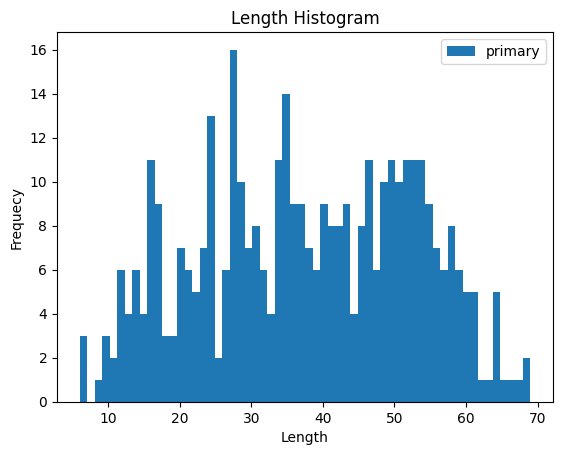

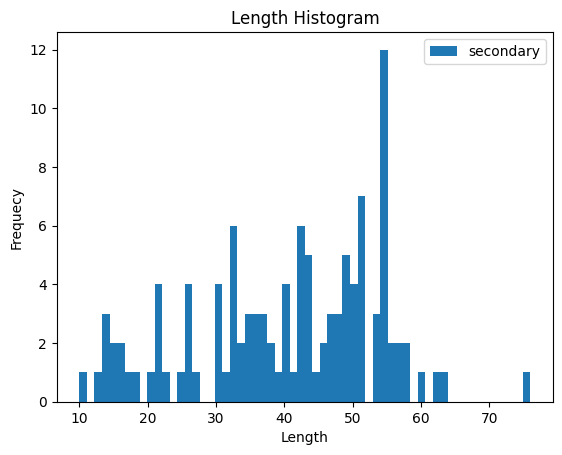

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
plt.hist(a,bins= 80, label = "non-reporting")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(b,bins= 60, label = "third-party")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(c, bins= 60, label = "primary")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(d, bins= 60, label = "secondary")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()

# BERT

In [89]:
!pip install transformers
from tokenizers import BertWordPieceTokenizer
import transformers
from transformers import RobertaTokenizer, TFRobertaModel


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Tokenization is cutting input data into parts (symbols) that can be mapped (embedded) into a vector space. 

In [90]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased', lower=True)

# Save the loaded tokenizer locally
# tokenizer.save_pretrained('.')

# tokenizer = transformers.BertTokenizerFast.from_pretrained('.')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer(os.path.join("/content/", "vocab.txt"), lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

## function for transforming and encoding into vector space

In [91]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=200):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

## Converting train, validation and test data into vector spaces

In [92]:
max_len=60
x_train_enc = fast_encode(x_train, fast_tokenizer, maxlen=max_len)
x_valid_enc = fast_encode(x_valid, fast_tokenizer, maxlen=max_len)
x_test_enc = fast_encode(x_test, fast_tokenizer, maxlen=max_len)

## Compiling the bert *model*

In [93]:
NUM_CLASSES = df_train['Sentiment_Cat'].nunique()
print(NUM_CLASSES)
# bert_transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)
bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2', num_labels=NUM_CLASSES)

# bert_transformer = transformers.TFRobertaForSequenceClassification.from_pretrained('vinai/bertweet-covid19-base-uncased', num_labels=NUM_CLASSES)

input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
sequence_output = bert_transformer(input)[0]
# cls_token = sequence_output[:, 0, :]
# output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cls_token)

model = tf.keras.Model(inputs=input, outputs=sequence_output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### summary of the model

In [94]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60)]              0         
                                                                 
 tf_bert_for_sequence_classi  TFSequenceClassifierOutp  335145988
 fication_1 (TFBertForSequen  ut(loss=None, logits=(No           
 ceClassification)           ne, 4),                             
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
Total params: 335,145,988
Trainable params: 335,145,988
Non-trainable params: 0
_________________________________________________________________


## Fitting the model

In [105]:
# call backs
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    x_train_enc,
    y_train,
    batch_size=16,
    validation_data=(x_valid_enc, y_valid),
    epochs=50,
    # callbacks=[early_stop_callback]
    )

Epoch 1/50
89/89 [==============================] - 64s 722ms/step - loss: 0.2546 - accuracy: 0.9209 - val_loss: 0.4339 - val_accuracy: 0.8481
Epoch 2/50
89/89 [==============================] - 63s 711ms/step - loss: 0.1876 - accuracy: 0.9449 - val_loss: 0.5496 - val_accuracy: 0.8038
Epoch 3/50
89/89 [==============================] - 62s 698ms/step - loss: 0.1178 - accuracy: 0.9725 - val_loss: 0.5724 - val_accuracy: 0.8165
Epoch 4/50
89/89 [==============================] - 62s 701ms/step - loss: 0.1107 - accuracy: 0.9703 - val_loss: 0.5851 - val_accuracy: 0.8418
Epoch 5/50
89/89 [==============================] - 62s 694ms/step - loss: 0.0599 - accuracy: 0.9873 - val_loss: 0.5666 - val_accuracy: 0.8608
Epoch 6/50
89/89 [==============================] - 62s 697ms/step - loss: 0.0420 - accuracy: 0.9915 - val_loss: 0.6541 - val_accuracy: 0.8418
Epoch 7/50
89/89 [==============================] - 62s 696ms/step - loss: 0.0366 - accuracy: 0.9915 - val_loss: 0.7046 - val_accuracy: 0.8418

# USing the model for making prediction on Test Data

In [96]:
ypred = model.predict(x_test_enc)
ypred
df_test['ypred'] = np.argmax(ypred, axis=1)
df_test['ypred_cat'] = np.where(df_test['ypred']>=0.5, 1, 0)
df_test['ypred_cat'] = np.argmax(ypred, axis=1)
df_test

13/13 [==============================] - 12s 386ms/step


,id,tweet,tweet_cleaned,ypred,ypred_cat
0,1242353332817137664t,If you think you have been exposed to COVID-19...,if you think you have been exposed to covid 19...,0,0
1,1244712715827982339t,"@timbovisser @BBCJohnBeattie Yes, myself, wife...",timbovisser bbcjohnbeattie yes myself wife...,3,3
2,1314693013810089984t,Lots of people I know having positive covid te...,lots of people i know having positive covid te...,3,3
3,1307860995692527616t,@lizzyp144 @TomAThakkar Okay but doesn’t COVID...,lizzyp144 tomathakkar okay but does not covi...,0,0
4,1277375421164613632t,We should have people w covid cough on white b...,we should have people w covid cough on white b...,0,0
...,...,...,...,...,...
395,1255420681581404163t,#bbcgms People who don't have COVID-19 cough s...,bbcgms people who do not have covid 19 cough ...,0,0
396,1331420575265394688t,"Fatigue, shortness of breath, muscle aches, he...",fatigue shortness of breath muscle aches he...,2,2
397,1272691373645467653t,I woke up today from my nap and my throat was ...,i woke up today from my nap and my throat was ...,2,2
398,1242065925337018369t,"#coronavirusindia It's just beginning, isolati...",coronavirusindia it is just beginning isolat...,0,0


In [97]:
print(np.argmax(ypred, axis=1))

[0 3 3 0 0 2 0 1 0 2 0 1 0 0 0 2 0 0 3 3 0 0 0 2 2 0 0 3 0 0 1 0 3 0 0 2 1
 0 0 1 3 1 0 0 0 0 0 0 2 0 2 3 2 0 2 0 0 0 0 0 0 2 0 0 0 1 0 0 3 0 2 3 0 0
 0 0 0 3 2 1 2 2 0 0 0 0 2 2 0 0 0 2 0 1 0 0 0 2 0 1 1 1 2 3 1 2 0 3 1 0 0
 0 2 0 2 2 0 0 0 1 3 3 2 0 3 2 2 0 0 2 3 1 0 2 2 3 3 0 0 2 0 0 0 2 0 0 1 3
 1 0 1 2 2 1 2 3 0 2 2 0 1 2 3 2 0 1 0 3 2 2 0 0 2 0 0 0 0 2 0 0 1 1 2 3 0
 0 0 1 2 0 0 0 0 1 0 0 0 2 2 3 2 0 2 1 3 0 0 2 0 3 2 0 0 2 3 2 0 2 2 1 0 0
 3 2 0 0 0 0 3 0 2 0 0 0 2 0 2 1 0 2 0 0 0 0 1 2 2 2 2 0 0 2 0 0 2 0 0 2 2
 0 0 2 2 2 2 1 2 0 0 0 2 0 2 2 0 0 2 0 0 0 2 1 3 0 0 2 2 0 0 3 0 2 3 0 1 2
 0 0 0 2 2 1 0 2 0 0 1 0 3 0 2 1 0 0 2 0 0 2 3 0 0 1 2 0 0 2 1 0 2 0 1 0 3
 0 3 0 3 2 3 0 2 0 1 2 2 2 2 0 0 0 0 0 0 0 0 0 1 0 0 2 1 0 0 0 1 1 3 0 2 3
 1 0 0 2 0 0 0 0 1 0 0 0 0 2 0 2 3 2 2 0 0 2 2 0 2 0 2 2 0 0]


## converting real number into numbers 0,1 and 2 reprsenting three classes

In [98]:
df_test['pred'] = np.argmax(ypred, axis=1)
df_test

,id,tweet,tweet_cleaned,ypred,ypred_cat,pred
0,1242353332817137664t,If you think you have been exposed to COVID-19...,if you think you have been exposed to covid 19...,0,0,0
1,1244712715827982339t,"@timbovisser @BBCJohnBeattie Yes, myself, wife...",timbovisser bbcjohnbeattie yes myself wife...,3,3,3
2,1314693013810089984t,Lots of people I know having positive covid te...,lots of people i know having positive covid te...,3,3,3
3,1307860995692527616t,@lizzyp144 @TomAThakkar Okay but doesn’t COVID...,lizzyp144 tomathakkar okay but does not covi...,0,0,0
4,1277375421164613632t,We should have people w covid cough on white b...,we should have people w covid cough on white b...,0,0,0
...,...,...,...,...,...,...
395,1255420681581404163t,#bbcgms People who don't have COVID-19 cough s...,bbcgms people who do not have covid 19 cough ...,0,0,0
396,1331420575265394688t,"Fatigue, shortness of breath, muscle aches, he...",fatigue shortness of breath muscle aches he...,2,2,2
397,1272691373645467653t,I woke up today from my nap and my throat was ...,i woke up today from my nap and my throat was ...,2,2,2
398,1242065925337018369t,"#coronavirusindia It's just beginning, isolati...",coronavirusindia it is just beginning isolat...,0,0,0


In [134]:
df_test.to_csv("task2_answer.csv")

## Validation set Accuracy, Precision and Recall

In [127]:
x_val_enc = fast_encode(x_valid, fast_tokenizer, maxlen=max_len)

In [128]:
ypred_val = model.predict(x_val_enc)
# ypred_val
df_valid['ypred'] = np.argmax(ypred_val, axis=1)
df_valid['ypred_cat'] = np.where(df_valid['ypred']>=0.5, 1, 0)
df_valid['ypred_cat'] = np.argmax(ypred_val, axis=1)
df_valid

5/5 [==============================] - 2s 387ms/step


<ipython-input-128-e17c08647e3b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['ypred'] = np.argmax(ypred_val, axis=1)
<ipython-input-128-e17c08647e3b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['ypred_cat'] = np.where(df_valid['ypred']>=0.5, 1, 0)
<ipython-input-128-e17c08647e3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,id,tweet,labels,Sentiment_Cat,tweet_cleaned,ypred,ypred_cat,pred
492,1305487773168615425,Just came back from my first rapid test for co...,primary,NaN,just came back from my first rapid test for co...,2,2,primary
1165,1241524267839340545,@carolecadwalla Also key is the advice of feve...,secondary,NaN,carolecadwalla also key is the advice of feve...,3,3,secondary
1372,1241840199614648320,So...is a sore throat a symptom of COVID-19?,non-reporting,NaN,so is a sore throat a symptom of covid 19,0,0,non-reporting
779,1319817912945958912,Oh don’t worry about this cough. It’s not covi...,primary,NaN,oh do not worry about this cough it is not co...,2,2,primary
887,1235747235712741379,Meanwhile Google nowadays *Symptoms - Cough - ...,non-reporting,NaN,meanwhile google nowadays symptoms cough ...,0,0,non-reporting
...,...,...,...,...,...,...,...,...
469,1241278962216689666,Sis your really going out to a house party wit...,non-reporting,NaN,sis your really going out to a house party wit...,0,0,non-reporting
1335,1240019922404720645,dkdjjd someone said before covid you had to co...,non-reporting,NaN,dkdjjd someone said before covid you had to co...,0,0,non-reporting
1256,1271446598531366918,I know one more story of a friend telling me h...,non-reporting,NaN,i know one more story of a friend telling me h...,0,0,non-reporting
732,1247009410401984513,"Welp, the wife's got a horrible cough and cold...",secondary,NaN,welp the wife s got a horrible cough and cold...,3,3,secondary


In [129]:
df_valid['pred'] = np.argmax(ypred_val, axis=1)
df_valid

<ipython-input-129-5567e7e3fe32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['pred'] = np.argmax(ypred_val, axis=1)


,id,tweet,labels,Sentiment_Cat,tweet_cleaned,ypred,ypred_cat,pred
492,1305487773168615425,Just came back from my first rapid test for co...,primary,NaN,just came back from my first rapid test for co...,2,2,2
1165,1241524267839340545,@carolecadwalla Also key is the advice of feve...,secondary,NaN,carolecadwalla also key is the advice of feve...,3,3,3
1372,1241840199614648320,So...is a sore throat a symptom of COVID-19?,non-reporting,NaN,so is a sore throat a symptom of covid 19,0,0,0
779,1319817912945958912,Oh don’t worry about this cough. It’s not covi...,primary,NaN,oh do not worry about this cough it is not co...,2,2,2
887,1235747235712741379,Meanwhile Google nowadays *Symptoms - Cough - ...,non-reporting,NaN,meanwhile google nowadays symptoms cough ...,0,0,0
...,...,...,...,...,...,...,...,...
469,1241278962216689666,Sis your really going out to a house party wit...,non-reporting,NaN,sis your really going out to a house party wit...,0,0,0
1335,1240019922404720645,dkdjjd someone said before covid you had to co...,non-reporting,NaN,dkdjjd someone said before covid you had to co...,0,0,0
1256,1271446598531366918,I know one more story of a friend telling me h...,non-reporting,NaN,i know one more story of a friend telling me h...,0,0,0
732,1247009410401984513,"Welp, the wife's got a horrible cough and cold...",secondary,NaN,welp the wife s got a horrible cough and cold...,3,3,3


## Converting y_pred from number to String Category

In [130]:
y_map_inv = {
    0: 'non-reporting',
    1: 'third-party',
    2: 'primary',
    3:'secondary'
}
# df_valid['pred'] = df_valid['pred'].map(y_map_inv)

In [122]:
df_valid

,id,tweet,labels,Sentiment_Cat,tweet_cleaned,ypred,ypred_cat,pred
492,1305487773168615425,Just came back from my first rapid test for co...,primary,NaN,just came back from my first rapid test for co...,2,2,primary
1165,1241524267839340545,@carolecadwalla Also key is the advice of feve...,secondary,NaN,carolecadwalla also key is the advice of feve...,3,3,secondary
1372,1241840199614648320,So...is a sore throat a symptom of COVID-19?,non-reporting,NaN,so is a sore throat a symptom of covid 19,0,0,non-reporting
779,1319817912945958912,Oh don’t worry about this cough. It’s not covi...,primary,NaN,oh do not worry about this cough it is not co...,2,2,primary
887,1235747235712741379,Meanwhile Google nowadays *Symptoms - Cough - ...,non-reporting,NaN,meanwhile google nowadays symptoms cough ...,0,0,non-reporting
...,...,...,...,...,...,...,...,...
469,1241278962216689666,Sis your really going out to a house party wit...,non-reporting,NaN,sis your really going out to a house party wit...,0,0,non-reporting
1335,1240019922404720645,dkdjjd someone said before covid you had to co...,non-reporting,NaN,dkdjjd someone said before covid you had to co...,0,0,non-reporting
1256,1271446598531366918,I know one more story of a friend telling me h...,non-reporting,NaN,i know one more story of a friend telling me h...,0,0,non-reporting
732,1247009410401984513,"Welp, the wife's got a horrible cough and cold...",secondary,NaN,welp the wife s got a horrible cough and cold...,3,3,secondary


In [119]:
# df_test1["id"]= df_test["id"]
df_valid.to_csv("DATA@IITD_task2_run1.csv")

In [131]:
df_valid.pred.value_counts()

0    76
2    48
1    21
3    13
Name: pred, dtype: int64

## Confusion Matrix of Validation Set

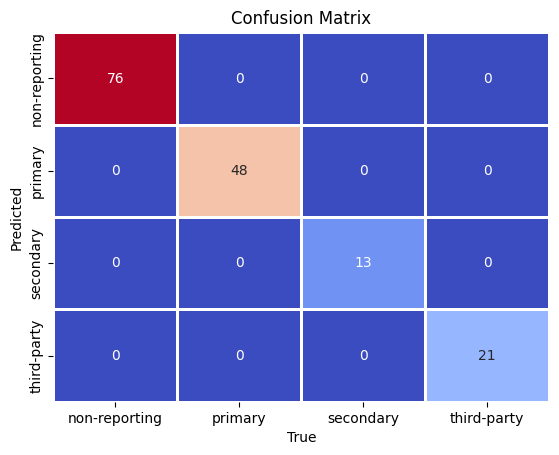

In [132]:
y_map_inv = {
    0: 'non-reporting',
    1: 'third-party',
    2: 'primary',
    3:'secondary'
}

#     'non-reporting': 0, 
#     'third-party': 1, 
#     'primary': 2,
#     'secondary':3

# y_map = {
#     'ProVax': 0, 
#     'AntiVax': 1, 
#     'Neutral': 2
# }

sns.heatmap(
    pd.crosstab(df_valid['pred'].map(y_map_inv), df_valid['ypred_cat'].map(y_map_inv)),
    annot=True,
    fmt='0.0f',
    cbar=False,
    linewidth=2,
    cmap='coolwarm'     
)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix');

### Importing accuracy_score, precision_score, recall_score, f1_score

In [133]:
y_test = df_valid['pred'].map(y_map_inv)
y_pred = df_valid['ypred'].map(y_map_inv)
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4']))


Confusion Matrix

[[76  0  0  0]
 [ 0 48  0  0]
 [ 0  0 13  0]
 [ 0  0  0 21]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00        76
     Class 2       1.00      1.00      1.00        48
     Class 3       1.00      1.00      1.00        13
     Class 4       1.00      1.00      1.00        21

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158

